<a href="https://colab.research.google.com/github/nakamura41/emotion_detection_notebooks/blob/master/ISEAR_Embedding_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gensim
!pip install pydrive

    100% |████████████████████████████████| 23.6MB 893kB/s 
    100% |████████████████████████████████| 1.4MB 12.1MB/s 
    100% |████████████████████████████████| 133kB 23.0MB/s 
    100% |████████████████████████████████| 4.8MB 6.9MB/s 
    100% |████████████████████████████████| 61kB 22.6MB/s 
    100% |████████████████████████████████| 552kB 22.3MB/s 
  Running setup.py bdist_wheel for smart-open ... - done
  Stored in directory: /root/.cache/pip/wheels/23/00/44/e5b939f7a80c04e32297dbd6d96fa3065af89ecf57e2b5f89f
  Running setup.py bdist_wheel for bz2file ... - done
  Stored in directory: /root/.cache/pip/wheels/81/75/d6/e1317bf09bf1af5a30befc2a007869fa6e1f516b8f7c591cb9
Successfully built smart-open bz2file
    100% |████████████████████████████████| 993kB 20.1MB/s 
  Running setup.py bdist_wheel for pydrive ... - done
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built pydrive


In [2]:
import os
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
import numpy as np
import urllib.request
import pandas as pd
from gensim.test.utils import common_texts, get_tmpfile
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec
from tempfile import gettempdir
import zipfile
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, brier_score_loss
import matplotlib.pyplot as plt
import seaborn as sns

print(tf.__version__)

1.12.0


Using TensorFlow backend.


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# download google drive file
def download_drive_file(drive_directory, filename):
  list_file_query = "title='{}' and trashed=false".format(drive_directory)
  file_list = drive.ListFile({'q': list_file_query}).GetList()

  if len(file_list) > 0:
    directory_id = file_list[0]['id']

    list_file_query = "'{}' in parents".format(directory_id)

    file_list = drive.ListFile({'q': list_file_query}).GetList()
    
    file_id = None
    for file1 in file_list:
      if file1['title'] == filename:
        print("downloading file {}".format(file1['title']))
        file1.GetContentFile(file1['title'])

In [0]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3" #@param ["https://tfhub.dev/google/universal-sentence-encoder/2", "https://tfhub.dev/google/universal-sentence-encoder-large/3"]

In [0]:
# Import the Universal Sentence Encoder's TF Hub module
tf_use_embed = hub.Module(module_url)

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.


In [0]:
sentences = ["I love you so much", "I hate that movie, there are no plotline or even interesting scenes"]
# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    embedded_sentences = session.run(tf_use_embed(sentences))
    for i, embedded_sentence in enumerate(np.array(embedded_sentences).tolist()):
        print("Sentence: {}".format(sentences[i]))
        print("Embedding size: {}".format(len(embedded_sentence)))
        message_embedding_snippet = ", ".join(
            (str(x) for x in embedded_sentence[:3]))
        print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

Sentence: I love you so much
Embedding size: 512
Embedding: [-0.03638805076479912, -0.07312509417533875, 0.007526352070271969, ...]

Sentence: I hate that movie, there are no plotline or even interesting scenes
Embedding size: 512
Embedding: [0.016185155138373375, 0.059069763869047165, -0.0056126900017261505, ...]



In [0]:
def embed_use(sentences):
    with tf.Session() as session:
        session.run([tf.global_variables_initializer(), tf.tables_initializer()])
        embedded_sentences = session.run(tf_use_embed(sentences))
        return embedded_sentences

In [0]:
class ISEARDataset(object):
  FILENAME = "isear_databank.csv"
  EMOTION_CLASSES = ["anger", "disgust", "fear", "guilt", "joy", "sadness", "shame"]
  EMOTION_CLASSES_DICT = {"anger": 0, "disgust": 1, "fear": 2, "guilt": 3, "joy": 4, "sadness": 5, "shame": 6}
  RANDOM_STATE = 41
  
  def get_classes(self):
    return self.EMOTION_CLASSES
  
  def get_classes_dict(self):
    return self.EMOTION_CLASSES_DICT
  
  def __load_data_file(self):
    download_drive_file("Datasets", self.FILENAME)
    data = pd.read_csv(self.FILENAME)
    data["emotion"] = data["Field1"]
    data["text"] = data["SIT"]
    return data[["text", "emotion"]]

  def load_data(self):
    train_data = None
    test_data = None
    
    data = self.__load_data_file()
    
    train_data, test_data = train_test_split(data, test_size=0.3, random_state=self.RANDOM_STATE, stratify=data["emotion"].values)
    return train_data, test_data

In [0]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (4,3), fontsize=15):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [6]:
isear_dataset = ISEARDataset()
train_data, test_data = isear_dataset.load_data()
train_data, valid_data = train_test_split(train_data, test_size=0.1, random_state=200, stratify=train_data.emotion)

print(train_data.shape)
print(valid_data.shape)
print(test_data.shape)

downloading file isear_databank.csv
(4829, 2)
(537, 2)
(2300, 2)


In [7]:
emotions = train_data.emotion.unique()
dic = dict()
labels = []
for i, emotion in enumerate(emotions):
    dic[emotion]=i
    labels.append(emotion)
print(dic)
print(labels)

{'guilt': 0, 'sadness': 1, 'fear': 2, 'anger': 3, 'joy': 4, 'disgust': 5, 'shame': 6}
['guilt', 'sadness', 'fear', 'anger', 'joy', 'disgust', 'shame']


In [0]:
train_labels = np.array(train_data.emotion.apply(lambda x:dic[x]))
test_labels = np.array(test_data.emotion.apply(lambda x:dic[x]))

# Embed with Universal Sentence Encoder

In [0]:
train_embedded_use = embed_use(train_data.text.tolist())
test_embedded_use = embed_use(test_data.text.tolist())

# Universal Sentence Encoder + SVM Classifier

In [0]:
from sklearn import svm
clfSVM = svm.SVC(C=10000.0, gamma='auto', kernel='rbf')
clfSVM.fit(train_embedded_use, train_labels)

SVC(C=10000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [0]:
test_pred_labels = clfSVM.predict(test_embedded_use)

In [0]:
cmSVM = confusion_matrix(test_labels, test_pred_labels)
cmSVM

In [0]:
reportSVM = classification_report(test_labels, test_pred_labels, target_names=labels)
print(reportSVM)

# TfIdfVectorizer + SVM Classifier

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=70, min_df=2, ngram_range=(1, 3))
train_tfidf_vectors = tfidf_vectorizer.fit_transform(train_data.text.tolist())
test_tfidf_vectors = tfidf_vectorizer.transform(test_data.text.tolist())

In [11]:
from sklearn import svm
clf_SVM_Tfidf = svm.SVC(C=10000.0, gamma='auto', kernel='rbf')
clf_SVM_Tfidf.fit(train_tfidf_vectors, train_labels)

SVC(C=10000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [0]:
test_pred_labels_Tfidf = clf_SVM_Tfidf.predict(test_tfidf_vectors)

In [13]:
cmSVM_Tfidf = confusion_matrix(test_labels, test_pred_labels_Tfidf)
cmSVM_Tfidf

array([[144,  27,  14,  62,  12,  18,  51],
       [ 24, 171,  15,  43,  30,  20,  26],
       [ 23,  20, 207,  21,  18,  19,  20],
       [ 50,  23,   9, 159,  15,  38,  35],
       [ 17,  17,  14,  18, 233,  14,  15],
       [ 16,  19,  18,  53,   7, 181,  35],
       [ 64,  15,  21,  39,  18,  26, 146]])

Figure(288x216)


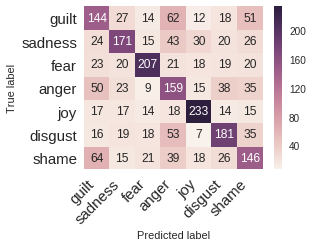

In [45]:
print(print_confusion_matrix(cmSVM_Tfidf, class_names=labels))

In [14]:
reportSVM = classification_report(test_labels, test_pred_labels_Tfidf, target_names=labels)
print(reportSVM)

             precision    recall  f1-score   support

      guilt       0.43      0.44      0.43       328
    sadness       0.59      0.52      0.55       329
       fear       0.69      0.63      0.66       328
      anger       0.40      0.48      0.44       329
        joy       0.70      0.71      0.70       328
    disgust       0.57      0.55      0.56       329
      shame       0.45      0.44      0.44       329

avg / total       0.55      0.54      0.54      2300



# CountVectorizer + SVM Classifier

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

# Initialize a CountVectorizer object: count_vectorizer
count_vectorizer = CountVectorizer(stop_words="english", analyzer='word', 
                                   ngram_range=(1, 3), max_df=70, min_df=2, max_features=None)

train_count_vectors = count_vectorizer.fit_transform(train_data.text.tolist())
test_count_vectors = count_vectorizer.transform(test_data.text.tolist())

clf_NB_count = MultinomialNB(alpha=0.1)
clf_SVM_count = svm.SVC(C=10000.0, gamma='auto', kernel='rbf')
clf_NB_count.fit(train_count_vectors, train_labels)
clf_SVM_count.fit(train_count_vectors, train_labels)

SVC(C=10000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [16]:
# get the feature names as numpy array
feature_names = np.array(count_vectorizer.get_feature_names())

# Sort the coefficients from the model
sorted_coef_index = clf_NB_count.coef_[0].argsort()

# Find the 10 smallest and 10 largest coefficients
# The 10 largest coefficients are being indexed using [:-11:-1] 
# so the list returned is in order of largest to smallest
print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs:
['junior' 'moment life' 'moment didn' 'mom' 'molested' 'molest'
 'misunderstand' 'moments' 'mistreated' 'missed train university']

Largest Coefs: 
['guilt' 'caught' 'hurt' 'promised' 'help' 'feel guilty' 'realized'
 'reason' 'forgot' 'able']


In [17]:
test_pred_labels_count = clf_SVM_count.predict(test_count_vectors)

cmSVM_count = confusion_matrix(test_labels, test_pred_labels_count)
cmSVM_count

array([[ 94,  46,  32,  57,  20,  30,  49],
       [ 32, 153,  31,  34,  45,  12,  22],
       [ 28,  43, 162,  26,  20,  25,  24],
       [ 53,  47,  26, 103,  28,  34,  38],
       [ 27,  37,  31,  14, 186,  18,  15],
       [ 30,  35,  33,  50,  27, 121,  33],
       [ 62,  41,  28,  36,  28,  29, 105]])

Figure(288x216)


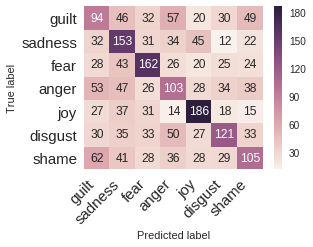

In [46]:
print(print_confusion_matrix(cmSVM_count, class_names=labels))

In [18]:
reportSVM = classification_report(test_labels, test_pred_labels_count, target_names=labels)
print(reportSVM)

             precision    recall  f1-score   support

      guilt       0.29      0.29      0.29       328
    sadness       0.38      0.47      0.42       329
       fear       0.47      0.49      0.48       328
      anger       0.32      0.31      0.32       329
        joy       0.53      0.57      0.55       328
    disgust       0.45      0.37      0.40       329
      shame       0.37      0.32      0.34       329

avg / total       0.40      0.40      0.40      2300



# CV 5 fold with CountVectorizer + TfIdfTransformer + SVM Classifier 

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

# Define a pipeline combining a text feature extractor with a simple
# classifier
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', svm.SVC()),
])

# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    # 'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2), (1, 3)),  # unigrams or bigrams
    'tfidf__use_idf': (True, False),
    # 'tfidf__norm': ('l1', 'l2'),
    'clf__C': (10000.0,),
    'clf__gamma': ('auto',),
    'clf__kernel': ('rbf',),
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=1)

grid_search.fit(train_data.text.tolist(), train_labels)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 12.5min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'vect__max_df': (0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2), (1, 3)), 'tfidf__use_idf': (True, False), 'clf__C': (10000.0,), 'clf__gamma': ('auto',), 'clf__kernel': ('rbf',)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [21]:
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.535
Best parameters set:
	clf__C: 10000.0
	clf__gamma: 'auto'
	clf__kernel: 'rbf'
	tfidf__use_idf: True
	vect__max_df: 0.5
	vect__ngram_range: (1, 2)


In [22]:
test_pred_labels_grid = grid_search.predict(test_data.text.tolist())

cmSVM_grid = confusion_matrix(test_labels, test_pred_labels_grid)
cmSVM_grid

array([[155,   7,  22,  77,  11,  28,  28],
       [ 37, 161,  20,  51,  22,  17,  21],
       [ 24,  12, 209,  32,  17,  21,  13],
       [ 34,  11,  19, 209,  11,  30,  15],
       [ 10,   9,   8,  37, 226,  24,  14],
       [ 14,   8,  26,  51,   5, 201,  24],
       [ 62,   5,  33,  46,  15,  42, 126]])

Figure(288x216)


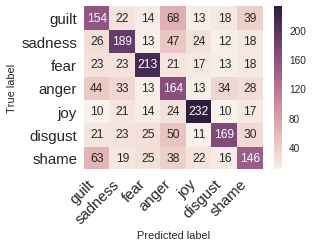

In [47]:
print(print_confusion_matrix(cmSVM_grid, class_names=labels))

In [23]:
reportSVM_grid = classification_report(test_labels, test_pred_labels_grid, target_names=labels)
print(reportSVM_grid)

             precision    recall  f1-score   support

      guilt       0.46      0.47      0.47       328
    sadness       0.76      0.49      0.59       329
       fear       0.62      0.64      0.63       328
      anger       0.42      0.64      0.50       329
        joy       0.74      0.69      0.71       328
    disgust       0.55      0.61      0.58       329
      shame       0.52      0.38      0.44       329

avg / total       0.58      0.56      0.56      2300



# CV 5 fold with CountVectorizer + TfIdfTransformer + SGDClassifier 

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfTransformer

# Define a pipeline combining a text feature extractor with a simple
# classifier
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier()),
])

# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    # 'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    # 'tfidf__use_idf': (True, False),
    # 'tfidf__norm': ('l1', 'l2'),
    'clf__max_iter': (5,),
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
    # 'clf__max_iter': (10, 50, 80),
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=1)

grid_search.fit(train_data.text.tolist(), train_labels)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   38.4s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'vect__max_df': (0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'clf__max_iter': (5,), 'clf__alpha': (1e-05, 1e-06), 'clf__penalty': ('l2', 'elasticnet')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [25]:
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.547
Best parameters set:
	clf__alpha: 1e-05
	clf__max_iter: 5
	clf__penalty: 'l2'
	vect__max_df: 0.75
	vect__ngram_range: (1, 2)


In [26]:
train_pred_labels_grid = grid_search.predict(train_data.text.tolist())

cmSVM_grid = confusion_matrix(train_labels, train_pred_labels_grid)
cmSVM_grid

array([[676,  13,   0,   0,   0,   0,   0],
       [  0, 690,   0,   0,   0,   0,   0],
       [  0,   3, 687,   0,   0,   0,   0],
       [  1,   5,   0, 683,   0,   0,   1],
       [  0,   2,   0,   0, 688,   0,   0],
       [  0,   7,   2,   0,   0, 681,   0],
       [  4,  15,   0,   0,   0,   0, 671]])

In [0]:
test_pred_labels_grid = grid_search.predict(test_data.text.tolist())

cmSVM_grid = confusion_matrix(test_labels, test_pred_labels_grid)
cmSVM_grid

array([[154,  22,  14,  68,  13,  18,  39],
       [ 26, 189,  13,  47,  24,  12,  18],
       [ 23,  23, 213,  21,  17,  13,  18],
       [ 44,  33,  13, 164,  13,  34,  28],
       [ 10,  21,  14,  24, 232,  10,  17],
       [ 21,  23,  25,  50,  11, 169,  30],
       [ 63,  19,  25,  38,  22,  16, 146]])

Figure(288x216)


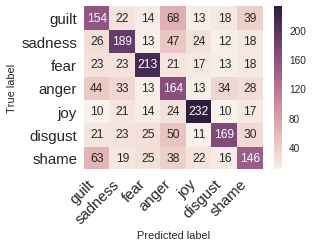

In [48]:
print(print_confusion_matrix(cmSVM_grid, class_names=labels))

In [28]:
reportSVM_grid = classification_report(test_labels, test_pred_labels_grid, target_names=labels)
print(reportSVM_grid)

             precision    recall  f1-score   support

      guilt       0.45      0.47      0.46       328
    sadness       0.57      0.57      0.57       329
       fear       0.67      0.65      0.66       328
      anger       0.40      0.50      0.44       329
        joy       0.70      0.71      0.70       328
    disgust       0.62      0.51      0.56       329
      shame       0.49      0.44      0.47       329

avg / total       0.56      0.55      0.55      2300



# spaCy vectorization + SVM Classifier

In [29]:
!python -m spacy download en_core_web_lg

    100% |████████████████████████████████| 852.3MB 32.1MB/s 
  Running setup.py install for en-core-web-lg ... - \ | / - \ | / - \ | / done

    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_lg -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en_core_web_lg

    You can now load the model via spacy.load('en_core_web_lg')



In [0]:
import spacy

nlp = spacy.load('en_core_web_lg')
train_spacy_vectors = train_data.text.apply(lambda x: nlp(x).vector).tolist()
test_spacy_vectors = test_data.text.apply(lambda x: nlp(x).vector).tolist()

In [31]:
clf_SVM_spacy = svm.SVC(C=10000.0, gamma='auto', kernel='rbf')
clf_SVM_spacy.fit(train_spacy_vectors, train_labels)

SVC(C=10000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [32]:
test_pred_labels_spacy = clf_SVM_spacy.predict(test_spacy_vectors)

cmSVM_spacy = confusion_matrix(test_labels, test_pred_labels_spacy)
cmSVM_spacy

array([[159,  26,  17,  54,  10,  15,  47],
       [ 33, 177,  21,  29,  36,  14,  19],
       [ 29,  20, 204,  17,  21,  19,  18],
       [ 56,  27,  17, 155,  10,  31,  33],
       [ 18,  37,  14,  19, 212,  12,  16],
       [ 19,  24,  28,  50,  11, 164,  33],
       [ 76,  20,  25,  36,  21,  29, 122]])

In [33]:
reportSVM_spacy = classification_report(test_labels, test_pred_labels_spacy, target_names=labels)
print(reportSVM_spacy)

             precision    recall  f1-score   support

      guilt       0.41      0.48      0.44       328
    sadness       0.53      0.54      0.54       329
       fear       0.63      0.62      0.62       328
      anger       0.43      0.47      0.45       329
        joy       0.66      0.65      0.65       328
    disgust       0.58      0.50      0.54       329
      shame       0.42      0.37      0.40       329

avg / total       0.52      0.52      0.52      2300



# Using spaCy TextCategorizer

In [34]:
labels

['guilt', 'sadness', 'fear', 'anger', 'joy', 'disgust', 'shame']

In [35]:
from spacy.pipeline import TextCategorizer

model = 'en_core_web_lg'
nlp = spacy.load(model)  # load existing spaCy model
print("Loaded model '%s'" % model)

textcat = nlp.create_pipe('textcat')
nlp.add_pipe(textcat, last=True)

Loaded model 'en_core_web_lg'


In [36]:
# assign label
for label in labels:
    textcat.add_label(label)
    
textcat.labels

['guilt', 'sadness', 'fear', 'anger', 'joy', 'disgust', 'shame']

In [0]:
train_texts = train_data.text.tolist()
valid_texts = valid_data.text.tolist()
test_texts = test_data.text.tolist()

train_labels = np.array(train_data.emotion.apply(lambda x:dic[x]))
valid_labels = np.array(valid_data.emotion.apply(lambda x:dic[x]))
test_labels = np.array(test_data.emotion.apply(lambda x:dic[x]))

In [0]:
def to_spacy_categorical(label_data, labels):
    new_data = dict()
    for label in labels:
        new_data[label] = (label_data == label)
    return new_data

In [0]:
train_encoded_labels = np.array(train_data.emotion.apply(lambda x:to_spacy_categorical(x, labels)))
valid_encoded_labels = np.array(valid_data.emotion.apply(lambda x:to_spacy_categorical(x, labels)))
test_encoded_labels = np.array(test_data.emotion.apply(lambda x:to_spacy_categorical(x, labels)))

In [40]:
train_encoded_labels

array([{'guilt': True, 'sadness': False, 'fear': False, 'anger': False, 'joy': False, 'disgust': False, 'shame': False},
       {'guilt': False, 'sadness': True, 'fear': False, 'anger': False, 'joy': False, 'disgust': False, 'shame': False},
       {'guilt': False, 'sadness': True, 'fear': False, 'anger': False, 'joy': False, 'disgust': False, 'shame': False},
       ...,
       {'guilt': False, 'sadness': False, 'fear': False, 'anger': False, 'joy': False, 'disgust': True, 'shame': False},
       {'guilt': False, 'sadness': True, 'fear': False, 'anger': False, 'joy': False, 'disgust': False, 'shame': False},
       {'guilt': False, 'sadness': False, 'fear': False, 'anger': True, 'joy': False, 'disgust': False, 'shame': False}],
      dtype=object)

In [0]:
train_spacy_data = list(zip(train_texts, [{'cats': cats} for cats in train_encoded_labels]))
valid_spacy_data = list(zip(valid_texts, [{'cats': cats} for cats in valid_encoded_labels]))
test_spacy_data = list(zip(test_texts, [{'cats': cats} for cats in test_encoded_labels]))

In [0]:
from spacy.util import minibatch

def evaluate(tokenizer, textcat, texts, cats):
    docs = (tokenizer(text) for text in texts)
    tp = 1e-8  # True positives
    fp = 1e-8  # False positives
    fn = 1e-8  # False negatives
    tn = 1e-8  # True negatives
    for i, doc in enumerate(textcat.pipe(docs)):
        gold = cats[i]
        for label, score in doc.cats.items():
            if label not in gold:
                continue
            if score >= 0.5 and gold[label] >= 0.5:
                tp += 1.
            elif score >= 0.5 and gold[label] < 0.5:
                fp += 1.
            elif score < 0.5 and gold[label] < 0.5:
                tn += 1
            elif score < 0.5 and gold[label] >= 0.5:
                fn += 1
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_score = 2 * (precision * recall) / (precision + recall)
    return {'textcat_p': precision, 'textcat_r': recall, 'textcat_f': f_score}


def training(spacy_nlp, train_data, valid_data, epoch=20):
    valid_texts, valid_labels = zip(*valid_data)
    
    other_pipes = [pipe for pipe in spacy_nlp.pipe_names if pipe != 'textcat']
    with spacy_nlp.disable_pipes(*other_pipes):  # only train textcat
        optimizer = spacy_nlp.begin_training()
        print("Training the model...")
        print('{:^5}\t{:^5}\t{:^5}\t{:^5}\t{:^5}'.format('EPOCH', 'LOSS', 'P', 'R', 'F'))
        for i in range(epoch):
            losses = {}
            # batch up the examples using spaCy's minibatch
            batches = minibatch(train_data, size=4)

            for batch in batches:
                texts, annotations = zip(*batch)
                spacy_nlp.update(texts, annotations, sgd=optimizer, drop=0.2, losses=losses)

            with textcat.model.use_params(optimizer.averages):
                # evaluate on the dev data split off in load_data()
                scores = evaluate(spacy_nlp.tokenizer, textcat, valid_texts, valid_labels)

            print('{0:.0f}\t{1:.3f}\t{2:.3f}\t{3:.3f}\t{4:.3f}'  # print a simple table
                  .format(i + 1, losses['textcat'], scores['textcat_p'],
                          scores['textcat_r'], scores['textcat_f']))

    return spacy_nlp

In [0]:
nlp = training(nlp, train_spacy_data, valid_spacy_data, epoch=20)